In [107]:
import numpy as np
import pandas as pd
import spacy
import networkx as nx
import score as sc
import time
from sklearn.metrics import confusion_matrix, pairwise
from scipy.spatial import distance
from preprocessing.utils import plot_confusion_matrix
import matplotlib.pyplot as plt
import nltk
from collections import Counter, defaultdict
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import itertools
import torch
import importlib

In [126]:
# import matplotlib.cm
# print(matplotlib.cm.cmap_d.keys())
import sys
importlib.reload(sys.modules['preprocessing.utils'])
from preprocessing.utils import plot_confusion_matrix

In [2]:
#https://github.com/huggingface/neuralcoref
#note: this NEEDS spacy 2.0.12 to work! downgrade with pip install spacy=2.0.12
import en_coref_md
nlp = spacy.load('en_core_web_sm')
coref = en_coref_md.load()

In [3]:
negating_words = set([
    "n't", "not", "no", 
    "never", "nobody", "non", "nope"])
doubting_words = set([
    'fake','fraud', 'hoax', 
    'false', 'deny', 'denies', 
    'despite', 'doubt', 
    'bogus', 'debunk', 'prank', 
    'retract', 'scam', "withdrawn",
    "misinformation"])
hedging_words = set([
    'allege', 'allegedly','apparently',
    'appear','claim','could',
    'evidently','largely','likely',
    'mainly','may', 'maybe', 'might',
    'mostly','perhaps','presumably',
    'probably','purport', 'purportedly',
    'reported', 'reportedly',
    'rumor', 'rumour', 'rumored', 'rumoured',
    'says','seem','somewhat',
    'unconfirmed'])
sus_words = doubting_words.union(hedging_words)

In [4]:
def get_batch(data, targets, i,batch_size):
    batches = data[i*batch_size:i*batch_size+batch_size]
    results = targets[i*batch_size:i*batch_size+batch_size]
    results = [(2.0 if result == "agree" else (1.0 if result == "discuss" else 0.0)) for result in results]
    batches = np.array(batches, dtype = "float")
    return batches, np.array(results)

def eval_model(model, data):
    correct = 0
    total = 0
    batch_x_test,batch_y_test = get_batch(data[0], data[1],0,len(stances_val))
    model.eval()
    predicted = None
    with torch.no_grad():
        inputs = Variable(torch.FloatTensor(batch_x_test))
        labels = torch.LongTensor(batch_y_test)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy: %d %%' % (100 * correct / total))
    return predicted

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

def train(model, total_batch, optimizer, criterion, data):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(data[0], data[1],i, batch_size)
        #print(batch_x, batch_y)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

def evaluate(model, total_batch, criterion, data):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i in range(total_batch):
            batch_x,batch_y = get_batch(data[0], data[1],i,batch_size)
            inputs = Variable(torch.FloatTensor(batch_x))
            labels = Variable(torch.LongTensor(batch_y))
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            _, predicted = torch.max(predictions.data, 1)
            acc = binary_accuracy(predicted, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    sent =  vader.polarity_scores(sentence.text)
    return [sent["pos"],sent["neg"],sent["neu"],sent["compound"]]

def get_avg_sentiment(lst):
    sents = np.array([get_sentiment(s) for s in lst])
    return list(np.mean(sents, axis = 0))

def get_diff_sentiment(a,b):
    return list(np.absolute(np.array(a) - np.array(b)))

In [6]:
def train_test_split(bodies, stances, split=0.8):
    idx = np.random.permutation(np.arange(len(bodies)))
    bodies = bodies.values[idx]
    train = int(len(bodies)*0.8)
    bodies_tr = set([i[0] for i in bodies[:train]])
    bodies_val = set([i[0] for i in bodies[train:]])
    stances_tr = stances.loc[stances["Body ID"].isin(bodies_tr), :]
    stances_val = stances.loc[stances["Body ID"].isin(bodies_val), :]
    return stances_tr, stances_val

In [7]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head(15)

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss
11,Woman detained in Lebanon is not al-Baghdadi's...,1468,agree
14,"Soon Marijuana May Lead to Ticket, Not Arrest,...",47,discuss
16,Boko Haram Denies Nigeria Cease-Fire Claim,2463,discuss
17,"No, Robert Plant Didn’t Rip Up an $800 Million...",295,agree
19,ISIL Beheads American Photojournalist in Iraq,608,discuss


In [8]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [41]:
stances_tr, stances_val = train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10713, 3), (2714, 3))

In [66]:
disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
agrees = stances_tr[stances_tr["Stance"]=="agree"]
discusses = stances_tr[stances_tr["Stance"]=="discuss"]
stances_tr_augmented = pd.concat([stances_tr, agrees, disagrees, disagrees, disagrees, disagrees, disagrees, disagrees]).sample(frac=1).reset_index(drop=True)

In [11]:
def get_body(n):
    return train_bodies.loc[lambda x: x["Body ID"] == n, "articleBody"].item()

In [12]:
def preprocess(text):
    text = text.replace("' ",' ')
    text = text.replace(" '",' ')
    text = text.replace(":", ". ")
    text = text.replace(";", ". ")
    return text

In [13]:
def cosine_similarity(x,y):
    return 1 - np.nan_to_num(distance.cosine(x,y))

In [14]:
def get_topics(doc):
    """
    get topics of a sentence
    input: spacy doc
    output: dictionary with nouns as the key, and the set of noun chunks that contain the noun as the value
    special entry _vocab has the set of all tokens in the dict
    """
    subjs = {}
    for token in doc:
        if token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "dobj", "dative", "attr", "oprd", "pobj", "compound"]:
            txt = token.lemma_.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])      
    for chunk in doc.noun_chunks:
        if len(chunk.root.text) > 2:
            txt = chunk.root.text.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])
            subjs[txt].add(chunk.text.lower())
    subjects_= []
    for word in subjs:
        for phrase in subjs[word]:
            subjects_ += phrase.split(" ")
    subjs["_vocab"] = set(subjects_)
    return subjs

In [15]:
def get_svos(sent):
    """
    input: Spacy processed sentence
    output: dict of subj, dict of v, dict of obj (each word is lemmatized and lowercased)
    each entry in dict has key of lemmatized token, value is actual token (to do traversals with later if needed)
    """
    s = {}
    v = {}
    o = {}
    for token in sent:
        if token.dep_ == 'ROOT':
            v[token.lemma_.lower()] = token
        elif token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "agent","compound"]:
            s[token.lemma_.lower()] = token
        elif token.dep_ in ["dobj", "dative", "attr", "oprd", "pobj"]:
            o[token.lemma_.lower()] = token
    # https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md
    return (s,v,o)

In [16]:
def build_graph(doc):
    """
    build a NetworkX graph of the dependency tree
    input: spacy Doc
    output: networkx graph
    """
    edges = set()
    for token in doc:
        for child in token.children:
            edges.add((token.lemma_.lower(),child.lemma_.lower()))
    graph = nx.Graph(list(edges))
    return graph

In [17]:
def get_summary(doc, subjects, n = 5):
    """
    get summary of n sentences in document
    first meaningful sentence will always be returned
    """
    subjects_ = subjects["_vocab"]
    def score_sentence(sent):
        # not very robust right now
        score = 0
        word_count = 0
        for token in sent:
            word_count += 1
            t = token.lemma_.lower()
            if t in subjects_:
                score += 1
            elif t in negating_words or t in doubting_words or t in hedging_words:
                score += 0.5
            return score/word_count if word_count > 4 else 0
    sentences = [s for s in doc.sents]
    scored_sentences = [[idx, sent, score_sentence(sent)] for idx, sent in enumerate(sentences)]
    # scored_sentences = [s for s in scored_sentences if s[2] > 0] #filter out non-scoring sentences
    scored_sentences.sort(key = lambda x: x[2], reverse = True)
    top = scored_sentences[:n-1]
    top.sort(key = lambda x: x[0])
    result = [scored_sentences[0][1]] + [s[1] for s in top]
    return result

In [18]:
def get_shortest_path_to_negating(graph, subjects):
    """
    get the shortest path from each subject to any negating or doubting/hedging word
    returns: dictionary with subject as key, and 2-element list of path lengths [negating, doubting]
    - if a subject does not exist in graph or have a path to any negating word, then the value will be [None, None]
    """
    results = {}
    for s in subjects:
        results[s] = [None, None]
        if graph.has_node(s):
            for word in negating_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][0] == None or len(path) < results[s][0]:
                            results[s][0] = len(path)
                    except:
                        continue
            for word in sus_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][1] == None or len(path) < results[s][1]:
                            results[s][1] = len(path)
                    except:
                        continue
    return results

In [19]:
def root_distance(graph, root):
    """
    as implemented in the Emergent paper - return the shortest distance between the given root and any 
    doubting or hedging words in the graph, or None if no such path exists
    """
    if root == None:
        return None
    min_dist = None
    for word in sus_words:
        if word in graph:
            try:
                path = nx.shortest_path(graph, source = root, target = word)
                if min_dist == None or len(path) < min_dist:
                    min_dist = len(path)
            except:
                continue
    return min_dist

In [20]:
def get_neg_ancestors(doc):
    """
    get the ancestors of every negating word
    input: spacy Doc
    returns: tuple  - set of words that were in the ancestor list of negating words, 
    set of words that were in ancestor list of refuting words, # negating words, # refuting words
    """
    results = [set(), set(), 0, 0]
    for token in doc:
        if token.lemma_.lower() in negating_words:
            results[0] = results[0].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2])
            )
            results[2] += 1
        elif token.lemma_.lower() in sus_words:
            results[1] = results[1].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2])
            )
            results[3] += 1
    return tuple(results)

In [76]:
h_id = 20
df = agrees
test = nlp(preprocess(list(df.values)[h_id][0]))
print(test)
test_graph = build_graph(test)
test_subj = get_topics(test)
test_svo = get_svos(test)
print(get_shortest_path_to_negating(test_graph, test_subj))
print(test_subj, test_svo, list(test_svo[1].keys())[0])
print(root_distance(test_graph, list(test_svo[1].keys())[0]))
print(get_neg_ancestors(test))

Jeh Johnson.  Politicians Shouldn't Feed The Flames Of Fear Over ISIS, Ebola
{'jeh': [None, None], 'politician': [3, None], 'flames': [3, None], 'fear': [5, None], 'isis': [None, None], 'ebola': [None, None], 'johnson': [None, None], 'politicians': [None, None], 'over': [None, None], '_vocab': [None, None]}
{'jeh': {'jeh'}, 'politician': {'politician'}, 'flames': {'flames', 'the flames'}, 'fear': {'fear'}, 'isis': {'isis'}, 'ebola': {'ebola'}, 'johnson': {'jeh johnson', 'johnson'}, 'politicians': {'politicians'}, 'over': {'over'}, '_vocab': {'jeh', 'fear', 'isis', 'politicians', 'flames', 'ebola', 'politician', 'over', 'the', 'johnson'}} ({'jeh': Jeh, 'politician': Politicians}, {'johnson': Johnson, 'feed': Feed, 'over': Over}, {'flames': Flames, 'fear': Fear, 'isis': ISIS, 'ebola': Ebola}) johnson
None
({'feed'}, set(), 1, 0)


In [77]:
body_text = get_body(list(df.values)[h_id][1])
body = coref(preprocess(body_text))
resolved = body._.coref_resolved
print(resolved)
print("")
body = nlp(resolved)
body_graph = build_graph(body)
summary = get_summary(body, test_subj, 5)
print(summary)
for s in summary:
    svo_s = get_svos(s)
    print(get_shortest_path_to_negating(body_graph, test_subj))
    print(svo_s)
    print(root_distance(body_graph, list(svo_s[1].keys())[0]))
    print(get_neg_ancestors(s))
    print("")

Homeland Security Secretary Jeh Johnson says Islamic State militants are not entering the U.S. through the southern border. Homeland Security Secretary Jeh Johnson was responding to a claim made by Rep. Duncan Hunter, R-Calif., that at least 10 Islamic State operatives were detained trying to come in from Mexico.

“We have no credible, specific intelligence to that effect,” Homeland Security Secretary Jeh Johnson said on CNN Wednesday evening of the militants also known as ISIS. “And I look at the intelligence reports from overseas from our southern border from our intelligence community virtually every day, numerous times a day, to be on the lookout for something of that nature. So, what I’d say to the American public is we’re vigilant in looking out for individuals of suspicion who may be crossing we .”

Johnson never mentioned Hunter by name, but Johnson has called on lawmakers to act responsibly and not frighten Americans. “Let’s not unduly create fear and anxiety in the American p

In [21]:
headline_info = {}
body_info = {}
start = time.time()
stance_data = list(train_stances.values)
body_data = list(train_bodies.values)
for headline in range(len(stance_data)):
    if headline % 2500 == 0:
        print("Processed "+str(headline))
    h, b_id, s = tuple(stance_data[headline])
    nlp_h = nlp(preprocess(h))
    headline_graph = build_graph(nlp_h)
    headline_subj = get_topics(nlp_h)
    headline_svo = get_svos(nlp_h)
    headline_root_dist = root_distance(headline_graph, list(headline_svo[1].keys())[0])
    headline_neg_ancestors = get_neg_ancestors(nlp_h)
    nqh = 0
    for tok in nlp_h:
        if tok.text == "?":
            nqh += 1
    headline_info[h] = (nlp_h, headline_graph, headline_subj, headline_svo, headline_root_dist, headline_neg_ancestors, nqh)
print("Done!")
for body in range(len(body_data)):
    if body % 100 == 0:
        print("Processed "+str(body))
    b_id, txt = tuple(body_data[body])
    nlp_a = coref(preprocess(txt))
    nlp_b = nlp(nlp_a._.coref_resolved)
    body_graph = build_graph(nlp_b)
    nqb = 0
    for tok in nlp_b:
        if tok.text == "?":
            nqb += 1
    body_info[b_id] = (nlp_b, body_graph, nqb)
print("Done!")
end = time.time()
print(int(end-start))

Processed 0
Processed 2500
Processed 5000
Processed 7500
Processed 10000
Processed 12500
Done!
Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600
Done!
783


In [147]:
def get_sentence_vec(s):
    vecs = [token.vector for token in s]
    return np.nan_to_num(np.sum(vecs, axis = 0))

def get_features(stance_df, n_sent = 5):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        headline, headline_graph, headline_subjs, headline_svo, headline_root_dist, headline_neg_ancestors, nq_h  = headline_info[h]
        body, body_graph, nq_b = body_info[b]
        
        #sometimes the coref deletes bodies that are one sentence
        if len(body) == 0:
            body = nlp(preprocess(get_body(b)))
            body_graph = build_graph(body)

        #return the shortest path to negating word for each subject in headline_subjs, if one exists
        neg_h = get_shortest_path_to_negating(headline_graph, headline_subjs)
        neg_b = get_shortest_path_to_negating(body_graph, headline_subjs)

        #body summary
        summary = get_summary(body, headline_subjs, n_sent)
        first_summ_sentence = summary[0]
        
        summary_svos = [get_svos(s) for s in summary]
        summary_root_dist = [root_distance(body_graph, list(s[1].keys())[0]) for s in summary_svos]
        summary_neg_ancestors = [get_neg_ancestors(s) for s in summary]
        summary_neg_counts = [s[2:] for s in summary_neg_ancestors]
        
        #svo
        body_s, body_v, body_o = {}, {}, {}
        headline_s, headline_v, headline_o = headline_svo
        for svo in summary_svos:
            body_s.update(svo[0])
            body_v.update(svo[1])
            body_o.update(svo[2])
        body_s_vec = list(np.sum([body_s[s].vector for s in body_s], axis = 0)) if len(body_s) > 0 else np.zeros(384)
        body_v_vec = list(np.sum([body_v[s].vector for s in body_v], axis = 0)) if len(body_v) > 0 else np.zeros(384)
        body_o_vec = list(np.sum([body_o[s].vector for s in body_o], axis = 0)) if len(body_o) > 0 else np.zeros(384)
    
        headline_s_vec = list(np.sum([headline_s[s].vector for s in headline_s], axis = 0)) if len(headline_s) > 0 else np.zeros(384)
        headline_v_vec = list(np.sum([headline_v[s].vector for s in headline_v], axis = 0)) if len(headline_v) > 0 else np.zeros(384)
        headline_o_vec = list(np.sum([headline_o[s].vector for s in headline_o], axis = 0)) if len(headline_o) > 0 else np.zeros(384)
        
        cos_sim_s = cosine_similarity(body_s_vec, headline_s_vec)
        cos_sim_v = cosine_similarity(body_v_vec, headline_v_vec)
        cos_sim_o = cosine_similarity(body_o_vec, headline_o_vec)
        
        #negating paths
        headline_paths = [neg_h[x] for x in neg_h]
        headline_neg_paths = [1 if x[0] != None else 0 for x in headline_paths] + [1]
        headline_hedge_paths = [1 if x[1] != None else 0 for x in headline_paths] + [1]
        body_paths = [neg_h[x] for x in neg_h]
        body_neg_paths = [1 if x[0] != None else 0 for x in body_paths] + [1]
        body_hedge_paths = [1 if x[1] != None else 0 for x in body_paths] + [1]
        
        neg_path_cos_sim = cosine_similarity(headline_neg_paths, body_neg_paths)
        hedge_path_cos_sim = cosine_similarity(headline_hedge_paths, body_hedge_paths)
        
        #root distance
        avg_summary_root_dist = None
        non_null = [x for x in summary_root_dist if x != None]
        if len(non_null) != 0:
            avg_summary_root_dist = sum(non_null)/len(non_null)
        root_dist_feats = [headline_root_dist, avg_summary_root_dist]
        root_dist_feats = [x if x != None else 100 for x in root_dist_feats]
    
        #sentiment
        headline_sent = get_sentiment(headline)
        body_sents = [get_sentiment(s) for s in summary]
        diff_sents = list(np.sum([get_diff_sentiment(headline_sent, s) for s in body_sents], axis = 0))
        
        #bow
        headline_vocab = set([tok.lemma_.lower() for tok in headline])
        fst_summ_vocab = set([tok.lemma_.lower() for tok in first_summ_sentence])
        total_vocab = list(headline_vocab.union(fst_summ_vocab))
        headline_embedding = [1 if tok in headline_vocab else 0 for tok in total_vocab]
        fst_summ_embedding = [1 if tok in fst_summ_vocab else 0 for tok in total_vocab]
        bow_cos_sim = cosine_similarity(headline_embedding, fst_summ_embedding)
        
        #word vecs
        cos_sims = [cosine_similarity(get_sentence_vec(s), headline.vector) for s in summary]
        fst_cos_sim = cos_sims[0]
        avg_cos_sim = sum(cos_sims)/len(cos_sims)
        
        #build final features list
        fts = (
            [fst_cos_sim, avg_cos_sim, bow_cos_sim, 
               neg_path_cos_sim, hedge_path_cos_sim, 
               cos_sim_s, cos_sim_v, cos_sim_o, nq_h, nq_b] + 
            headline_sent + diff_sents + root_dist_feats + 
            list(headline_neg_ancestors[2:]) + list(np.sum(summary_neg_counts, axis = 0))
        )
        features.append(fts)
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return features, actual

In [134]:
def get_features_nn(stance_df, n_sent = 5):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        headline, headline_graph, headline_subjs, headline_svo, headline_root_dist, headline_neg_ancestors, nq_h  = headline_info[h]
        body, body_graph, nq_b = body_info[b]
        
        #sometimes the coref deletes bodies that are one sentence
        if len(body) == 0:
            body = nlp(preprocess(get_body(b)))
            body_graph = build_graph(body)

        #return the shortest path to negating word for each subject in headline_subjs, if one exists
        neg_h = get_shortest_path_to_negating(headline_graph, headline_subjs)
        neg_b = get_shortest_path_to_negating(body_graph, headline_subjs)

        #body summary
        summary = get_summary(body, headline_subjs, n_sent)
        first_summ_sentence = summary[0]
        
        summary_svos = [get_svos(s) for s in summary]
        summary_root_dist = [root_distance(body_graph, list(s[1].keys())[0]) for s in summary_svos]
        summary_neg_ancestors = [get_neg_ancestors(s) for s in summary]
        summary_neg_counts = [s[2:] for s in summary_neg_ancestors]
        
        #svo
        body_s, body_v, body_o = {}, {}, {}
        headline_s, headline_v, headline_o = headline_svo
        for svo in summary_svos:
            body_s.update(svo[0])
            body_v.update(svo[1])
            body_o.update(svo[2])
        body_s_vec = list(np.mean([body_s[s].vector for s in body_s], axis = 0)) if len(body_s) > 0 else np.zeros(384)
        body_v_vec = list(np.mean([body_v[s].vector for s in body_v], axis = 0)) if len(body_v) > 0 else np.zeros(384)
        body_o_vec = list(np.mean([body_o[s].vector for s in body_o], axis = 0)) if len(body_o) > 0 else np.zeros(384)
    
        headline_s_vec = list(np.mean([headline_s[s].vector for s in headline_s], axis = 0)) if len(headline_s) > 0 else np.zeros(384)
        headline_v_vec = list(np.mean([headline_v[s].vector for s in headline_v], axis = 0)) if len(headline_v) > 0 else np.zeros(384)
        headline_o_vec = list(np.mean([headline_o[s].vector for s in headline_o], axis = 0)) if len(headline_o) > 0 else np.zeros(384)
        
        cos_sim_s = cosine_similarity(body_s_vec, headline_s_vec)
        cos_sim_v = cosine_similarity(body_v_vec, headline_v_vec)
        cos_sim_o = cosine_similarity(body_o_vec, headline_o_vec)
        
        #negating paths
        headline_paths = [neg_h[x] for x in neg_h]
        headline_neg_paths = [1 if x[0] != None else 0 for x in headline_paths] + [1]
        headline_hedge_paths = [1 if x[1] != None else 0 for x in headline_paths] + [1]
        body_paths = [neg_h[x] for x in neg_h]
        body_neg_paths = [1 if x[0] != None else 0 for x in body_paths] + [1]
        body_hedge_paths = [1 if x[1] != None else 0 for x in body_paths] + [1]
        
        neg_path_cos_sim = cosine_similarity(headline_neg_paths, body_neg_paths)
        hedge_path_cos_sim = cosine_similarity(headline_hedge_paths, body_hedge_paths)
        
        #root distance
        avg_summary_root_dist = None
        non_null = [x for x in summary_root_dist if x != None]
        if len(non_null) != 0:
            avg_summary_root_dist = sum(non_null)/len(non_null)
        root_dist_feats = [headline_root_dist, avg_summary_root_dist]
        root_dist_feats = [x if x != None else 100 for x in root_dist_feats]
    
        #sentiment
        headline_sent = get_sentiment(headline)
        body_sents = [get_sentiment(s) for s in summary]
        diff_sents = list(np.sum([get_diff_sentiment(headline_sent, s) for s in body_sents], axis = 0))
        
        #bow
        headline_vocab = set([tok.lemma_.lower() for tok in headline])
        fst_summ_vocab = set([tok.lemma_.lower() for tok in first_summ_sentence])
        total_vocab = list(headline_vocab.union(fst_summ_vocab))
        headline_embedding = [1 if tok in headline_vocab else 0 for tok in total_vocab]
        fst_summ_embedding = [1 if tok in fst_summ_vocab else 0 for tok in total_vocab]
        bow_cos_sim = cosine_similarity(headline_embedding, fst_summ_embedding)
        
        #word vecs
        cos_sims = [cosine_similarity(s.vector, headline.vector) for s in summary]
        fst_cos_sim = cos_sims[0]
        avg_cos_sim = sum(cos_sims)/len(cos_sims)
        
        #build final features list
        fts = (
            [fst_cos_sim, avg_cos_sim, bow_cos_sim, 
               neg_path_cos_sim, hedge_path_cos_sim, 
               cos_sim_s, cos_sim_v, cos_sim_o, nq_h, nq_b] + 
            headline_sent + diff_sents + root_dist_feats + 
            list(headline_neg_ancestors[2:]) + list(np.sum(summary_neg_counts, axis = 0))
        )
        features.append(np.nan_to_num(fts))
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return features, actual

In [148]:
training_data = get_features(stances_tr_augmented, 5)
testing_data = get_features(stances_val, 5)

/Users/dannyyang/Library/Python/3.6/lib/python/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


127
15


In [142]:
# for i in range(30):
#     print(np.size(training_data[0][i]))

In [135]:
# for i in range(len(training_data[0][0])):
#     r = []
#     for row in training_data[0]:
#         r.append(row[i])
#     print(r[:25])

In [145]:
training_data = [np.nan_to_num(x) for x in training_data[0]], training_data[1]

In [150]:
print(Counter(training_data[1]), Counter(testing_data[1]))

Counter({'discuss': 7167, 'agree': 5744, 'disagree': 4718}) Counter({'discuss': 1742, 'agree': 806, 'disagree': 166})


In [96]:
c = Counter(testing_data[1])
baseline = c['discuss']/(c['agree']+c['disagree']+c['discuss'])
print(baseline)

0.6418570375829035


# SIMPLE MODELS

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
model = RandomForestClassifier(max_depth = 8 , n_estimators=250)
# model = LogisticRegression(max_iter = 200)
# model = SVC()
model.fit(training_data[0], training_data[1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [151]:
tr_acc = model.score(training_data[0], training_data[1])
print('{0:.2f}% training accuracy'.format(tr_acc*100))
val_acc = model.score(testing_data[0], testing_data[1])
print('{0:.2f}% validation accuracy'.format(val_acc*100))
print("Baseline comparison: {0:.2f}%".format((val_acc-baseline)*100))

76.24% training accuracy
68.72% validation accuracy
Baseline comparison: 4.53%


In [31]:
print(model.classes_, model.coef_)

AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

# Neural Nets

In [154]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate = F.relu(self.fc1(x_in))
        output = self.fc2(self.dropout(intermediate))
        return output

In [132]:
class GRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=1, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, hidden = self.rnn(x)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        fc = self.fc(hidden.squeeze(0))
        fc2 = self.fc2(F.relu(fc))
        return fc2

In [152]:
EMBEDDING_DIM = len(training_data[0][0])
HIDDEN_DIM = int(EMBEDDING_DIM/2)
OUTPUT_DIM = 3
DROPOUT = 0.3
num_epochs = 10
batch_size = 500

In [155]:
batches_train= int(len(training_data[1])/batch_size)
batches_val = int(len(testing_data[1])/batch_size)

mlp = MLP(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)
criterion = criterion = nn.CrossEntropyLoss()

In [156]:
start = time.time()
for epoch in range(num_epochs):

    train_loss, train_acc = train(mlp, batches_train, optimizer, criterion, training_data)
    valid_loss, valid_acc = evaluate(mlp, batches_val, criterion, testing_data)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
end = time.time()
print(int(end-start))

| Epoch: 01 | Train Loss: 5.388 | Train Acc: 37.99% | Val. Loss: 2.029 | Val. Acc: 62.20% |
| Epoch: 02 | Train Loss: 5.333 | Train Acc: 38.39% | Val. Loss: 2.003 | Val. Acc: 62.08% |
| Epoch: 03 | Train Loss: 5.273 | Train Acc: 37.91% | Val. Loss: 1.978 | Val. Acc: 61.84% |
| Epoch: 04 | Train Loss: 5.305 | Train Acc: 37.69% | Val. Loss: 1.953 | Val. Acc: 61.80% |
| Epoch: 05 | Train Loss: 5.196 | Train Acc: 37.55% | Val. Loss: 1.930 | Val. Acc: 61.56% |
| Epoch: 06 | Train Loss: 5.167 | Train Acc: 37.92% | Val. Loss: 1.907 | Val. Acc: 61.60% |
| Epoch: 07 | Train Loss: 5.156 | Train Acc: 37.18% | Val. Loss: 1.884 | Val. Acc: 61.48% |
| Epoch: 08 | Train Loss: 5.086 | Train Acc: 37.28% | Val. Loss: 1.862 | Val. Acc: 61.32% |
| Epoch: 09 | Train Loss: 4.997 | Train Acc: 37.50% | Val. Loss: 1.840 | Val. Acc: 61.24% |
| Epoch: 10 | Train Loss: 4.992 | Train Acc: 37.26% | Val. Loss: 1.819 | Val. Acc: 61.24% |
0


In [477]:
predicted = None
with torch.no_grad():
    inputs = Variable(torch.FloatTensor(np.array(testing_data[0])))
    labels = [(2.0 if result == "agree" else (1.0 if result == "discuss" else 0.0)) for result in testing_data[1]]
    labels = torch.LongTensor(labels)
    outputs = mlp(inputs)
    _, predicted = torch.max(outputs.data, 1)
    predicted = [("agree" if x == 2 else ("discuss" if x == 1 else "disagree")) for x in predicted]

In [157]:
actual = testing_data[1]
predicted = model.predict(testing_data[0])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    470    |    21     |    315    |     0     |
-------------------------------------------------------------
| disagree  |    43     |    45     |    78     |     0     |
-------------------------------------------------------------
|  discuss  |    308    |    84     |   1350    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2077.25 out of 2714.0	(76.53831982313928%)
Normalized confusion matrix
[[0.58312655 0.02605459 0.39081886]
 [0.25903614 0.27108434 0.46987952]
 [0.17680827 0.04822044 0.7749713 ]]


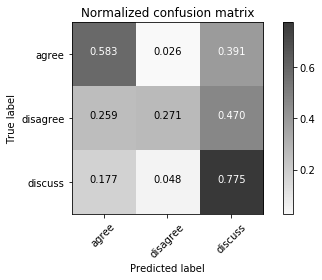

In [158]:
sc.report_score(actual, predicted)
matrix = confusion_matrix(actual,predicted)
plot_confusion_matrix(matrix, classes=["agree","disagree", "discuss"],
                      title='Normalized confusion matrix')
plt.show()